<a href="https://colab.research.google.com/github/OmarAlsaqa/Car_Commands_Classification/blob/master/Car_subCommands_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cleaning**

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
A = stopwords.words('english')

In [0]:
len(list(A))

179

In [0]:
# load data
filename = 'a.csv'
file = open(filename, 'rt')
text = file.read()
file.close()

# split into sentences
from nltk import sent_tokenize
sentences = sent_tokenize(text)
sentences = str(sentences[0])
#print(sentences)
sentences = sentences.split('\n')
print(sentences)

['on the radio', 'turn on the wireless radio', 'on the radio', 'turn on the radio', 'on radio', 'wireless radio on', 'radio wireless on', 'radio set on', 'radio on', 'turn along the radio on', 'turn the wireless radio on', 'turn the radio on', 'play the radio', 'play the radiocommunication', 'play the wireless radio', 'play the radio', 'play diddle radio', 'play radio', 'radio play', 'play radio', 'listen to the radio', 'listen to the mind radio', 'listen to the wireless', 'radio resume', 'resume radio', 'resume summarise radio', 'resume radio', 'resume', 'summarise resume', 'play off the radio', 'off the radio', 'turn off the radio', 'radio off', 'wireless radio off', 'wireless turn the radio off', 'bit the radio off', 'the turn radio off', 'turn the radio off', 'pause', 'interruption pause', 'pause', 'pause the radio', 'the pause radio', 'suspension the radio', 'pause the radio', 'full stop stop', 'stop', 'stop the radio', 'full stop stop the radio', 'halt the radio', 'stop full stop

In [0]:
# filter out stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
fuck = []
sente = ''
for sen in sentences:
  for word in sen.split(' '):
    if not word in stop_words:
      sente += word + ' '
  fuck.append(sente)
  sente = ''
final = [q[:-1] for q in fuck]

In [0]:
from pandas import DataFrame

df = DataFrame (final,columns=['cleaned'])
print(df)

                            cleaned
0                             radio
1               turn wireless radio
2                             radio
3                        turn radio
4                             radio
...                             ...
1552       less lights front lights
1553             lights back lights
1554  stake less lights back lights
1555  less stake lights back lights
1556        less lights back lights

[1557 rows x 1 columns]


In [0]:
df.to_csv(r'q.csv', index = False)

# **New**

## **Clasiification**

In [0]:
import json as j
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

In [0]:
with open('/content/subcommands.json') as json_file:
    itemData = j.load(json_file)

In [0]:
data = pd.DataFrame(itemData)

In [0]:
data[0:5]

,stars,text,cleaned
0,Radio radio on,on the radio,radio
1,Radio radio on,turn on the wireless radio,turn wireless radio
2,Radio radio on,on the radio,radio
3,Radio radio on,turn on the radio,turn radio
4,Radio radio on,on radio,radio


In [0]:
stemmer = SnowballStemmer('english')
words = stopwords.words("english")

In [0]:
data['cleaned'] = data['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [0]:
data[0:5]

,stars,text,cleaned
0,Radio radio on,on the radio,radio
1,Radio radio on,turn on the wireless radio,turn wireless radio
2,Radio radio on,on the radio,radio
3,Radio radio on,turn on the radio,turn radio
4,Radio radio on,on radio,radio


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned'], data.stars, test_size=0.2)

In [0]:
pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words="english", sublinear_tf=True)),
                     ('chi',  SelectKBest(chi2, k='all')),
                     ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))])

In [0]:
model = pipeline.fit(X_train, y_train)

In [0]:
vectorizer = model.named_steps['vect']
chi = model.named_steps['chi']
clf = model.named_steps['clf']

In [0]:
feature_names = vectorizer.get_feature_names()
feature_names = [feature_names[i] for i in chi.get_support(indices=True)]
feature_names = np.asarray(feature_names)

In [0]:
target_names = list(set(data['stars']))
print("top 10 keywords per class:")
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print("%s: %s" % (label, " ".join(feature_names[top10])))

top 10 keywords per class:
: harm light harm half lumin half light half denisti half band half growth light equilibr wheel yellow
GPS on: dam disfavour loc shit fun nice fantast perfect loc favorit rate come
Lights off: chang shape switch mode chang light mode dark mode mode delight current locat mode pleas current mode
seat seat heating: harm light harm half lumin half light half denisti half band half hide gas yellow check
window lower: harm half lumin half light half denisti half band half yellow nonetheless howev evalu
Radio FM: growth light growth degre growth grievous bodili half light shroud enshroud pin enshroud shroud restur hide
Radio music on: way loc locat loc situat loc equal loc way locat direct loc search loc know
GPS off: locact thtough rout nearest loc approxim navig approxim favorit path navig rout nearest
answer: turn gps stop global navig work navig stop gps shutdown occlus navig stop navig stop gps shutdown gps
read: global posit gps open workplac posit global sail

In [0]:
y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import classification_report
report = classification_report(list(y_test), list(y_pred), labels=list(set(data['stars'])), zero_division =1)
print(report)

                                  precision    recall  f1-score   support

                                       1.00      1.00      1.00         0
                          GPS on       0.60      1.00      0.75         3
                      Lights off       0.73      0.89      0.80         9
               seat seat heating       1.00      0.33      0.50         3
                    window lower       0.70      1.00      0.82         7
                        Radio FM       1.00      1.00      1.00         3
                  Radio music on       0.75      0.43      0.55         7
                         GPS off       1.00      0.50      0.67         4
                          answer       1.00      0.60      0.75         5
                            read       1.00      0.00      0.00         1
                         GPS add       0.44      1.00      0.61        11
                 seat headset on       0.00      1.00      0.00         0
                          wipers     

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


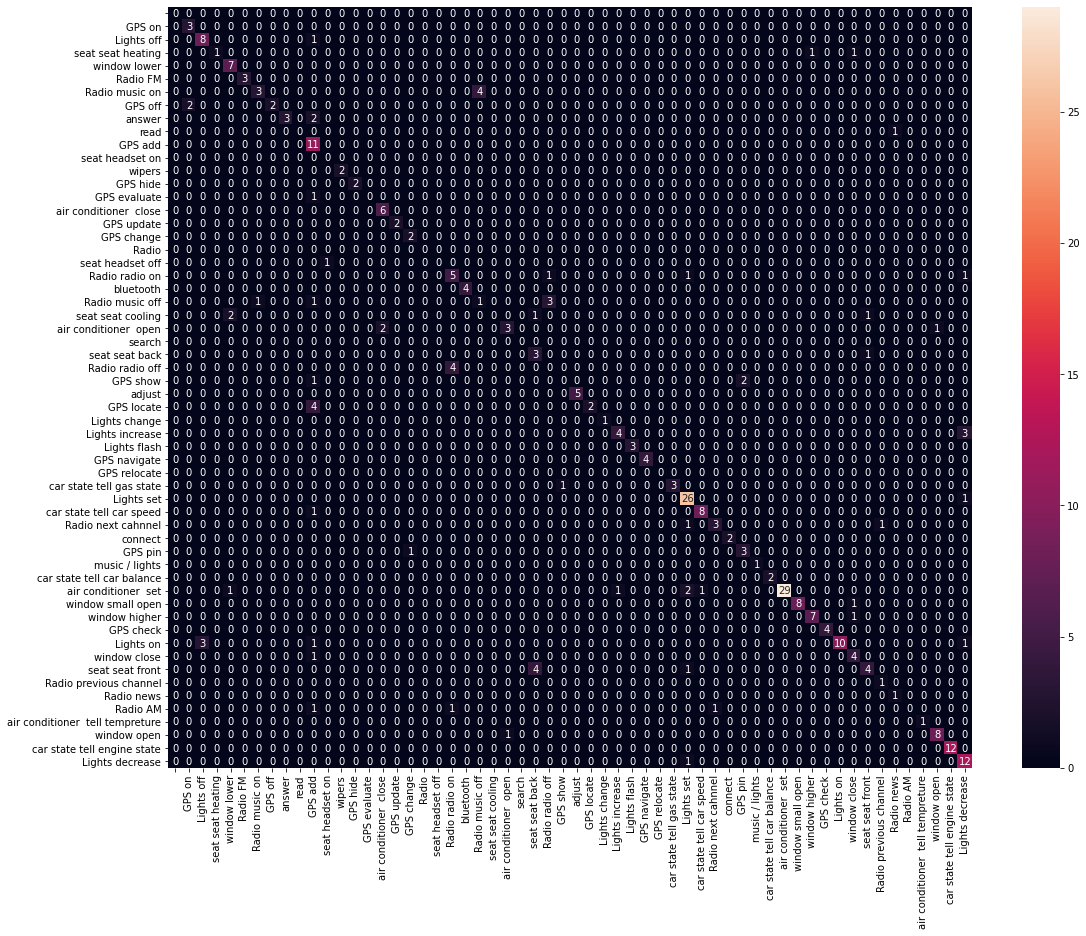

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(list(y_test), list(y_pred), labels= list(set(data['stars'])))

df_cm = pd.DataFrame(matrix,index = [i for i in (list(set(data['stars'])))],columns = [i for i in list(set(data['stars']))])
plt.figure(figsize = (18,14))
sn.heatmap(df_cm, annot=True)

In [0]:
from sklearn.metrics import accuracy_score
print("accuracy score: " + str(accuracy_score(list(y_test), list(y_pred))*100))

accuracy score: 76.6025641025641


In [0]:
print("accuracy score: " + str(model.score(X_test, y_test)*100))

accuracy score: 76.6025641025641


In [0]:
print(model.predict(['that was an awesome place']))

['GPS add']


In [0]:
print(model.predict(['there is dust use function wipers to clean it']))

['wipers']


In [0]:
print(model.predict(['turn on the lights']))

['window open']


In [0]:
print(model.predict(['turn on music']))

['Radio music on']


In [0]:
print(model.predict(['get me the news']))

['Radio news']


In [0]:
print(model.predict(['quiz me']))

['answer']


In [0]:
print(model.predict(['connect to device']))

['connect']


In [0]:
print(model.predict(['turn bluetooth the off']))

['bluetooth']


In [0]:
import pickle

pkl_filename = "textClass_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [0]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 76.60 %


In [0]:
print(model.predict([text]))

NameError: ignored